# Time Series Forecasting Youtube Tutorial
## Using Machine Learning to Forecast Energy Consumption

This notebook is accompanied by a Youtube tutorial.

[WATCH THE VIDEO HERE](https://youtu.be/vV12dGe_Fho)

[You can find it on my channel here!](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw)

![](https://res.cloudinary.com/monday-blogs/w_768,h_384,c_fit/fl_lossy,f_auto,q_auto/wp-blog/2021/05/sales-forecasting-software.jpg)

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

In [38]:
df = pd.read_csv('AEP_hourly_1.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


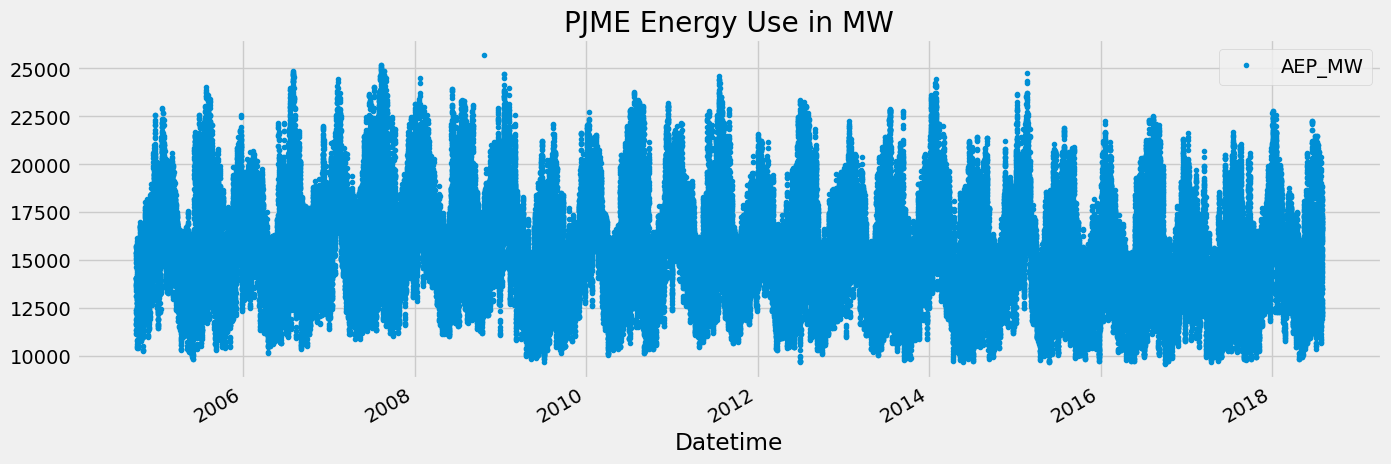

In [39]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# Train / Test Split

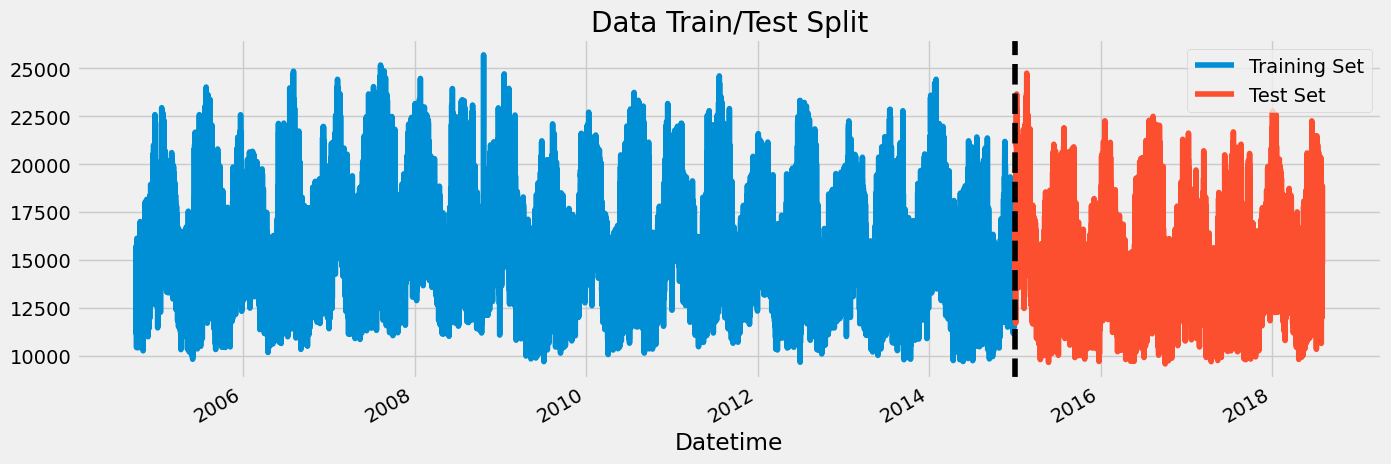

In [40]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

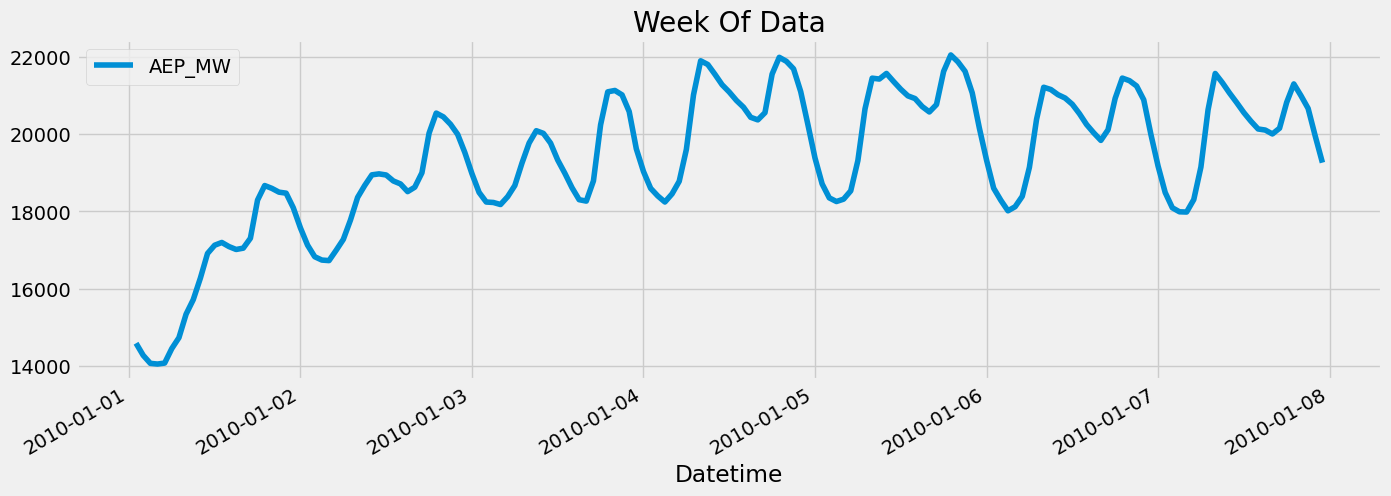

In [41]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [42]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

df

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,31,53
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,31,53
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366,31,53
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366,31,53
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366,31,53
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,21089.0,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,20999.0,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,20820.0,22,0,1,1,2018,1,1,1


# Visualize our Feature / Target Relationship

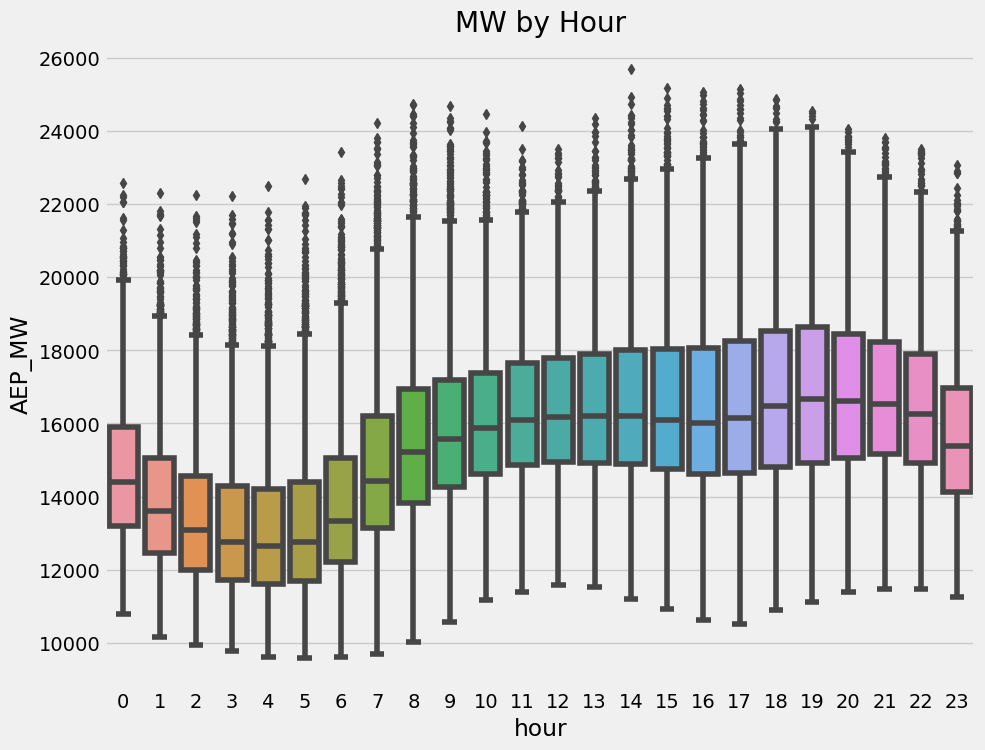

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

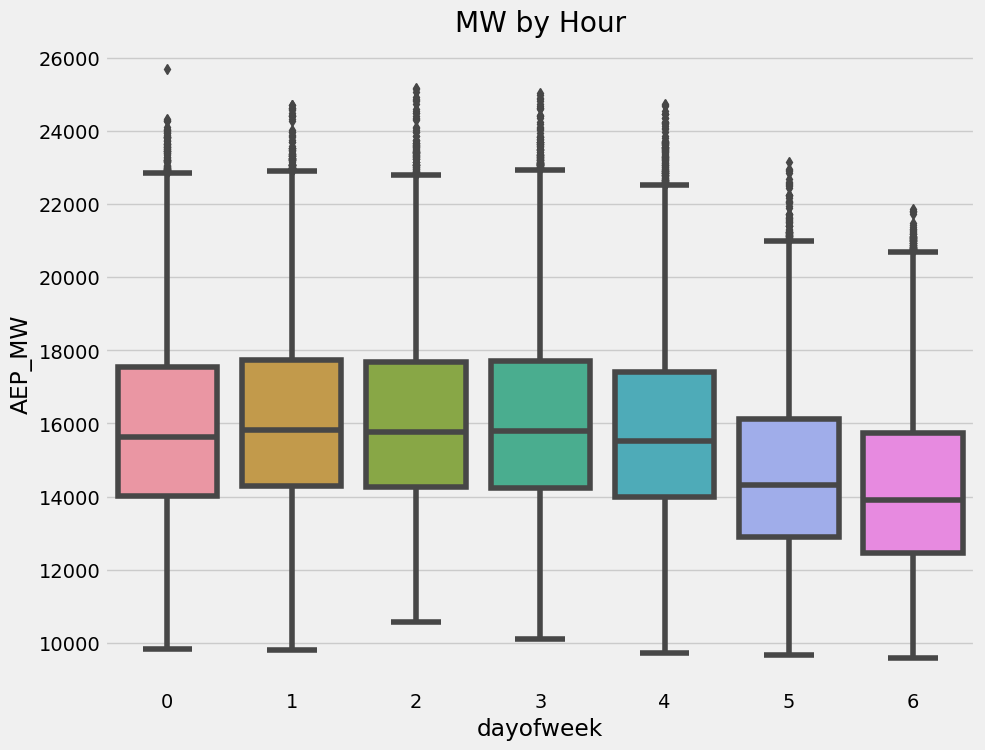

In [52]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

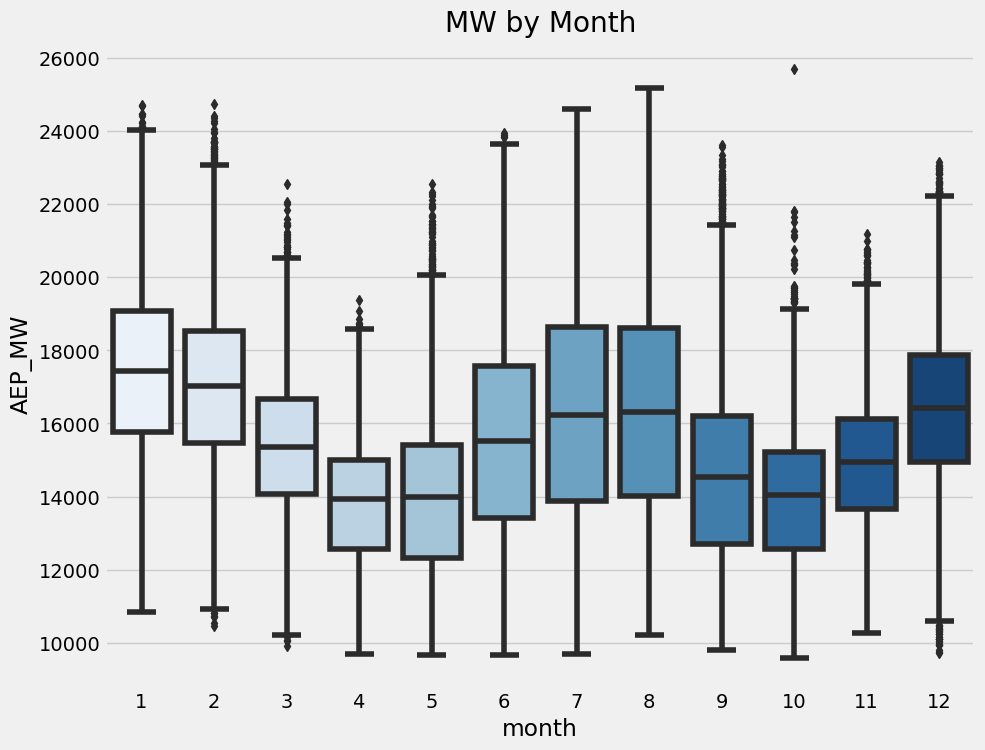

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [45]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

train.head(27)

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,31,53
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,31,53
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366,31,53
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366,31,53
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366,31,53
2004-12-31 06:00:00,13038.0,6,4,4,12,2004,366,31,53
2004-12-31 07:00:00,13692.0,7,4,4,12,2004,366,31,53
2004-12-31 08:00:00,14297.0,8,4,4,12,2004,366,31,53
2004-12-31 09:00:00,14719.0,9,4,4,12,2004,366,31,53


In [46]:
reg = xgb.XGBRegressor(base_score=0.9, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=50)

[20:03:55] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15792.86957	validation_1-rmse:14860.91123
[50]	validation_0-rmse:9676.41898	validation_1-rmse:8742.25738
[100]	validation_0-rmse:6033.77355	validation_1-rmse:5144.79423
[150]	validation_0-rmse:3896.10494	validation_1-rmse:3127.54566
[200]	validation_0-rmse:2702.81183	validation_1-rmse:2158.47651
[250]	validation_0-rmse:2070.80150	validation_1-rmse:1773.92545
[300]	validation_0-rmse:1754.97248	validation_1-rmse:1666.22639
[350]	validation_0-rmse:1598.39111	validation_1-rmse:1649.70288
[395]	validation_0-rmse:1522.98727	validation_1-rmse:1657.08656


XGBRegressor(base_score=0.9, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

# Feature Importance

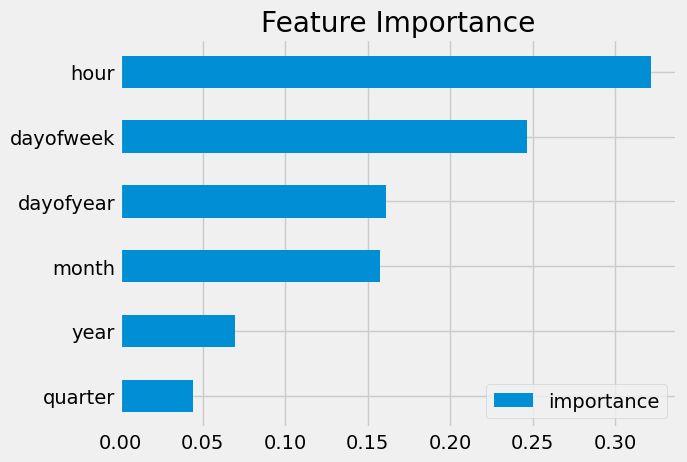

In [47]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

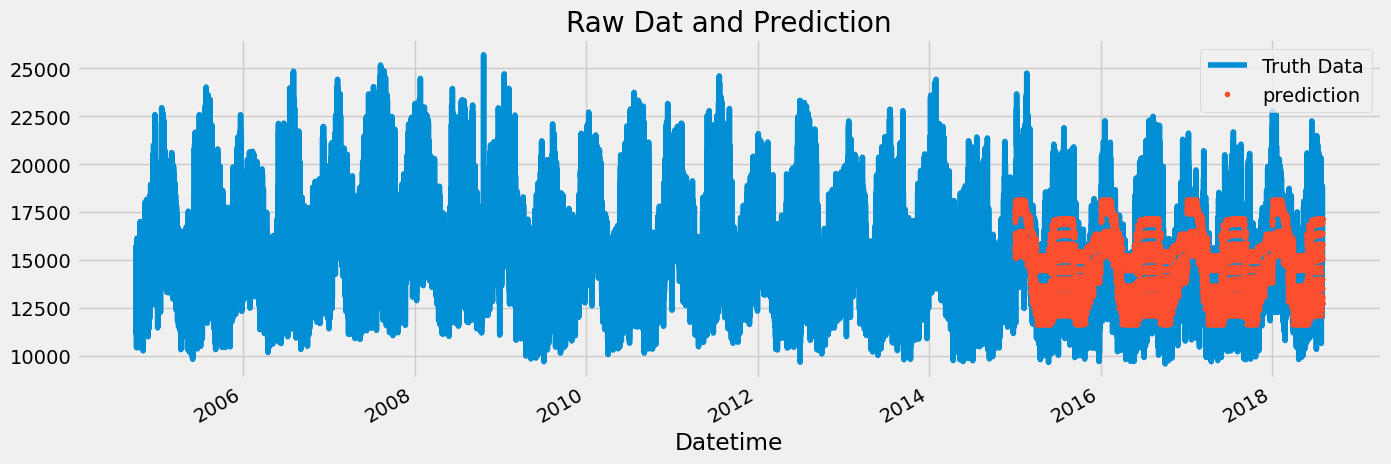

In [48]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'prediction'])
ax.set_title('Raw Dat and Prediction')
plt.show()

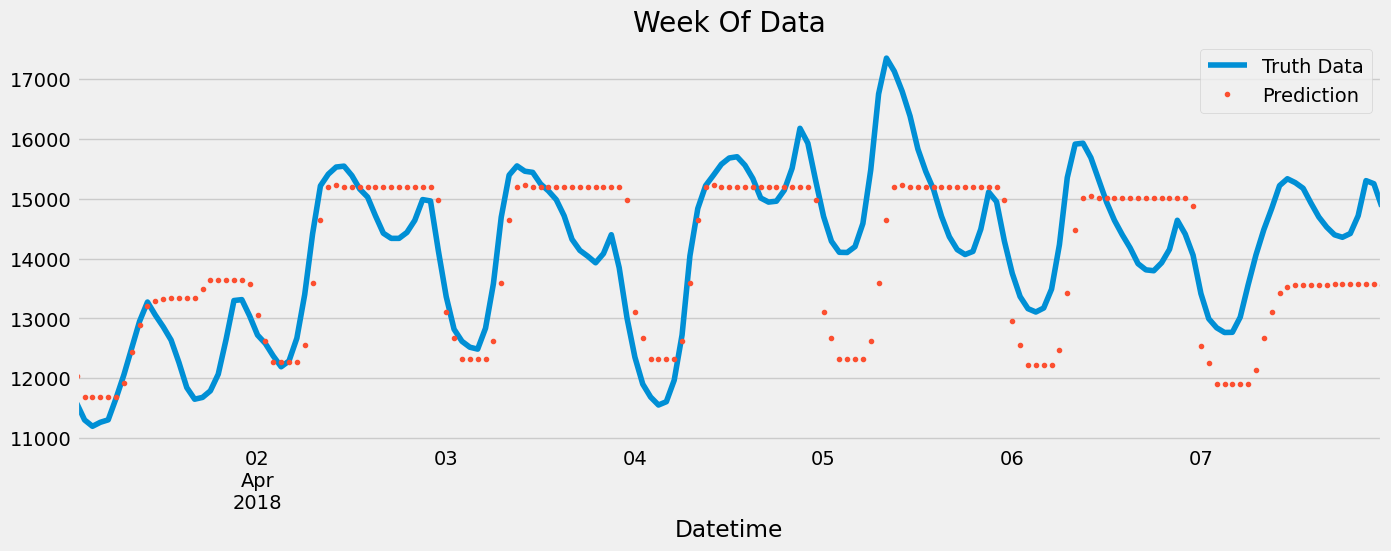

In [49]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [50]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1649.06


# Calculate Error
- Look at the worst and best predicted days

In [51]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-02-19    5654.228149
2015-02-20    5411.339355
2018-01-06    4804.667114
2015-01-08    4679.298787
2015-12-25    4468.447266
2015-02-16    4361.886108
2015-12-24    4198.238525
2018-01-05    4031.538493
2018-01-07    4022.528809
2015-02-15    4012.242065
Name: error, dtype: float64

# Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)

# The End